<a href="https://colab.research.google.com/github/jyj1206/BDA_9th_ML1/blob/main/4%EC%A3%BC%EC%B0%A8_%EC%9E%84%EA%B3%84%EA%B0%92_%EC%A1%B0%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 라이브러리 불러오기
import pandas as pd
import seaborn as sns
import numpy as np

df = sns.load_dataset('diamonds')
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
# 이진 분류 문제로 바꾸기 위해 Premium 이상인 경우 1, 그렇지 안으면 0으로 바꿈
df['cut_binary'] = df['cut'].apply(lambda x: 1 if x in ['Premium', 'Ideal'] else 0)

In [ ]:
# 간단하게 하기 위해 수치형 독립변수만 가져옴 + 종속 변수
df_sp = df[['depth', 'table', 'price', 'x', 'y', 'z', 'cut_binary']]
df_sp.head()

,depth,table,price,x,y,z,cut_binary
0,61.5,55.0,326,3.95,3.98,2.43,1
1,59.8,61.0,326,3.89,3.84,2.31,1
2,56.9,65.0,327,4.05,4.07,2.31,0
3,62.4,58.0,334,4.20,4.23,2.63,1
4,63.3,58.0,335,4.34,4.35,2.75,0


In [ ]:
# 결측치 확인
df_sp[df_sp.isna().any(axis=1)]

,depth,table,price,x,y,z,cut_binary


In [ ]:
# train, test 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_sp.drop('cut_binary',axis=1), df_sp['cut_binary'], test_size=0.3, random_state=111)

In [ ]:
# 평가 지표 함수 생성
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred, average='micro')
  recall = recall_score(y_test, pred, average='micro')
  print('오차 행렬')
  print(confusion)
  print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}')

In [ ]:
# LogisticRegression 모델 학습
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter = 500)

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[2861 2719]
 [1012 9590]]
정확도: 0.7694, 정밀도: 0.7694, 재현율: 0.7694


In [ ]:
# 예측 클래스 확인
pred

array([1, 0, 0, ..., 1, 1, 1])

In [ ]:
# predict proba를 확인
pred_proba = lr_clf.predict_proba(X_test)

In [ ]:
pred_proba

array([[0.44517569, 0.55482431],
       [0.60551824, 0.39448176],
       [0.6381203 , 0.3618797 ],
       ...,
       [0.25458278, 0.74541722],
       [0.20022677, 0.79977323],
       [0.12730209, 0.87269791]])

In [ ]:
# 임계값 조정을 위해 Binarizer 선언
from sklearn.preprocessing import Binarizer
binarizer = Binarizer(threshold=0.3)

In [ ]:
# 임계값 조정에 따른 결과
tt_pred = binarizer.fit_transform(pred_proba)[:,1].reshape(-1, 1)

In [ ]:
get_clf_eval(y_test, tt_pred)

오차 행렬
[[ 1311  4269]
 [  128 10474]]
정확도: 0.7283, 정밀도: 0.7283, 재현율: 0.7283


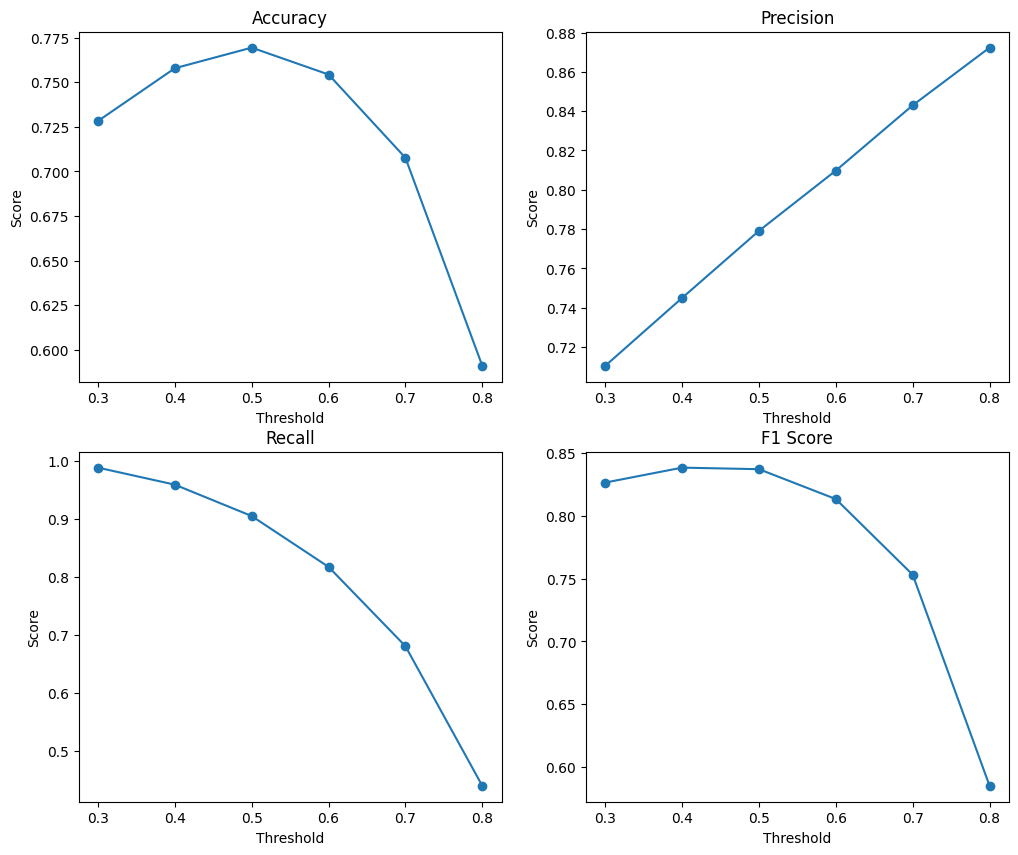

In [ ]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

thresholds= [0.3,0.4,0.5,0.6,0.7,0.8]

def get_eval_list(y_test, pred_proba, thresholds):
  accuracy_tt_list = []
  precision_tt_list = []
  recall_tt_list = []
  f1_tt_list = []

  for threshold in thresholds:
    binarizer = Binarizer(threshold=threshold)
    tt_pred = binarizer.fit_transform(pred_proba)[:,1].reshape(-1, 1)
    accuracy_tt = accuracy_score(y_test, tt_pred)
    precision_tt = precision_score(y_test, tt_pred)
    recall_tt = recall_score(y_test, tt_pred)
    f1_tt = f1_score(y_test, tt_pred)

    accuracy_tt_list.append(accuracy_tt)
    precision_tt_list.append(precision_tt)
    recall_tt_list.append(recall_tt)
    f1_tt_list.append(f1_tt)

  return accuracy_tt_list, precision_tt_list, recall_tt_list, f1_tt_list

def figure_eval(accuracy_tt_list, precision_tt_list, recall_tt_list, f1_tt_list, thresholds):
  fig, axes = plt.subplots(2, 2, figsize=(12, 10))
  metrics = [accuracy_tt_list, precision_tt_list, recall_tt_list, f1_tt_list]
  titles = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

  for i, ax in enumerate(axes.flat):
      ax.plot(thresholds, metrics[i], marker='o')
      ax.set_title(titles[i])
      ax.set_xlabel('Threshold')
      ax.set_ylabel('Score')

  plt.show()

accuracy_list, precision_list, recall_list, f1_list = get_eval_list(y_test, pred_proba, thresholds)
figure_eval(accuracy_list, precision_list, recall_list, f1_list, thresholds)

Threshold에 따라 평가지표들이 변함
- F1 score를 기준으로 0.4 ~ 0.5 사이의 값을 선택하는 것이 좋아보인다.